In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

datadir = '/home/mer49/Dropbox (Cambridge University)/Shared/Prannoy/Code/20200317 MER GPs/'

from util            import *
from basics          import *
from simulate_data   import *
from estimators      import *
from config          import *
from scipy.special   import *
from functools       import lru_cache as cache
from opt_einsum      import contract
from scipy.io        import loadmat
from IPython.display import clear_output
configure_pylab()

# Jax's fft is slow
# Numpy's fft pathologically casts to float64
# Scipy's seems ok
from scipy.fft import *

# This code benefits considerably from using single-precision floating point

# Set constants

In [2]:
tol    = 1e-4      # Newton convergence tolerance
mintol = 1e-5      # Minimum residual tolerance
L      = 128+32    # Grid size
T      = L*L       # Total number of basis functions 
res    = 50        # Upsampling/interpolation resolution when estimating period
pad    = 0.6       # Pad to avoid wrap-around from circular convolution; 0.5 = no padding
Fs     = 50.0      # Sample rate of data in Hz
Fl     = 0.25      # Low-frequency cutoff in Hz for smoothing path trajcetory for heading

# Find and load data

In [3]:
# 2D grid coordinates as complex numbers
coords = zgrid(L)
bins   = linspace(0,1,L+1,dtype='float64')

# Resolution for the camera used to record R1 is 350px/m;
# resolution for other rats (R11 and R18) was 338px/m
#px_p_meter = 338
#dataset    = 'R18_20200131_1to2_EC_good.mat'
#px_p_meter = 338
#dataset    = 'R11_20190607_1to2_EC_good.mat'
px_p_meter  = 350
dataset     = 'R1_20190823_2to1_EC_good.mat'
datasetname = dataset.split('_')[0]
dataset_ID  = re.match('(R\d+)_(\d+)',dataset).group(0)

# Load all datasets from this day
data = loadmat(datadir+dataset,squeeze_me=True)
xy50 = data['xy50'] # Position
sp50 = data['sp50'] # Spikes
hd50 = data['hd50'] # Head angle
ndatasets = len(xy50)

# Which datasets to process? 
do_datasets = [1]#range(ndatasets)

# Rescale location data from all datasets using same transformation
allxy50 = np0.concatenate(xy50)
x,y     = allxy50.T
minx,maxx,miny,maxy = np.min(x),np.max(x),np.min(y),np.max(y)
delta   = np0.max([maxx-minx,maxy-miny])
scale   = (1-1e-6)/(delta*pad*2)

# Record grid scale
bins_p_meter = scale*L*px_p_meter
cm_p_bin     = 100/bins_p_meter
print('cm per bin',cm_p_bin)

# Load a given dataset, rescaling the spatial locations
def load_dataset(fn,dataindex):
    # Get dataset
    data = loadmat(fn,squeeze_me=True)
    xy50 = data['xy50'] # Position
    sp50 = data['sp50'] # Spikes
    # Get specified dataset
    x,y  = xy50[dataindex].T
    s    = sp50[dataindex]
    x    = (x-(maxx+minx)/2+delta*pad)*scale
    y    = (y-(maxy+miny)/2+delta*pad)*scale
    return s,x,y,scale

def bin_spikes(x,y,s,bins,w=None):
    # Bin spike counts
    N    = histogram2d(y,x,(bins,bins),density=0,weights=w)[0]
    ws   = s if w is None else array(s)*array(w)
    K    = histogram2d(y,x,(bins,bins),density=0,weights=ws)[0]
    return N,K

cm per bin 2.534569882505151


P= 10.12


Text(0.5, 0.98, 'R1_20190823_2to1_EC_good.mat dataset 1')

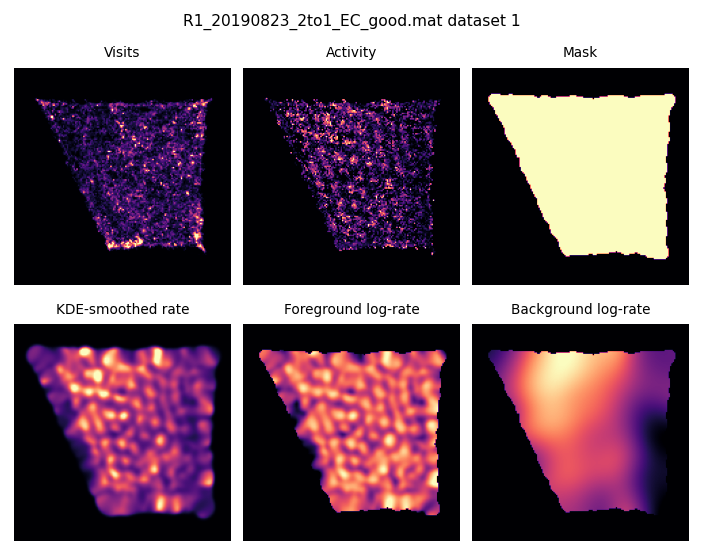

In [4]:
# Get specific dataset
idata = do_datasets[0]
s,x,y,scale = load_dataset(datadir+dataset,idata)

# Grab spikes
st    = find(s>0)
xs,ys = x[st],y[st]
sk    = s[st]
N,K   = bin_spikes(x,y,s,bins)
y1    = nan_to_num(K/N)
mask  = blur(N>0,2)>0.1

# Calibrate grid scale
λhat   = nan_to_num(K/N)
u      = outer(hanning(L),hanning(L))
acorr2 = fft_acorr(λhat*u,mask) # Get 2D autocorrelation
acorrR = radial_average(acorr2) # Get radial autocorrelation
res    = 50                     # Subsampling resolution
P,acup = acorr_peak(acorrR,res) # Distance to first peak in bins    

print('P=',P)
fgσ  = P/pi
bgσ  = fgσ*5
λhat = kdeλ(N,K,fgσ)
λbg  = kdeλ(N,K,bgσ)

# Precompute variables; Passed as globals to jac/hess
n    = N.ravel()               # Number of visits per bin
y    = nan_to_num(K/N).ravel() # Lumped pseudo-observerations
λhat = kdeλ(N,K,fgσ)           # KDE estimated rate
λbg  = kdeλ(N,K,bgσ)           # Background rate
lλh  = slog(λhat)              # Log rate
lλb  = slog(λbg)               # Log background
lλf  = lλh - lλb               # Foreground log rate

# Initial guess for kernel height
σ0   = zerolag(radial_acorr(lλf,mask))

figure(figsize=(5,4))
subplot(231)
showim(N,'Visits');
subplot(232)
showim(y1,'Activity');
subplot(233)
showim(mask,'Mask');
subplots_adjust(top=0.8)
suptitle('%s dataset %d'%(dataset,idata))
subplot(234)
showim(λhat,'KDE-smoothed rate');
subplot(235)
showim(lλf,'Foreground log-rate',mask=mask);
subplot(236)
showim(lλb,'Background log-rate',mask=mask);
tight_layout()
suptitle('%s dataset %d'%(dataset,idata))

# Define hyperparameter search grid

- β is the kernel height
- P is the kernel period

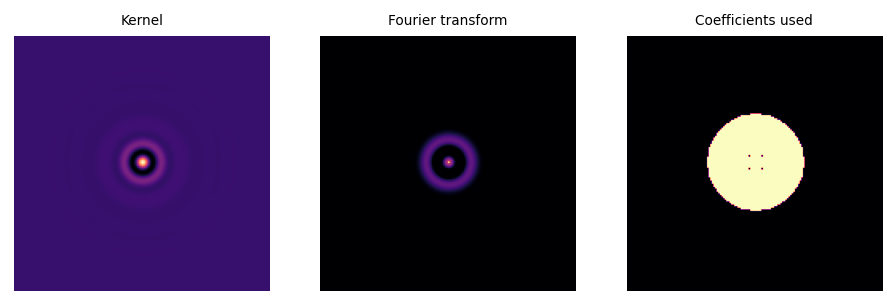

In [5]:
rP   = 2
rβ   = 10
P_lo = P/rP
P_hi = P*rP
β_lo = 1/rβ
β_hi = 1*rβ
NP   = 21
Nβ   = 21
Ps   = exp(linspace(log(P_lo),log(P_hi),NP))
βs   = exp(linspace(log(β_lo),log(β_hi),Nβ))[::-1]

@cache
def make_kernel_ft(L,P,σ0,dc=1e1,k=3):
    coords   = zgrid(L)
    window   = hanning(L)
    window   = fftshift(outer(window,window))
    kern     = j0(fftshift(abs(coords*2*pi/P)))*window
    clip     = fftshift(abs(coords)<P*jn_zeros(0,k)[-1]/(2*pi))
    kern     = kern*clip
    kern     = blur(kern,P/pi)
    kern     = repair_small_eigenvalues(kern*σ0/np.max(kern),1e-5)
    Kf       = np0.array(real(fft2(kern)))
    Kf[0,0] += dc
    return float64(Kf)

use2d = zeros((L,L),dtype='bool')
for p in Ps:
    Kf  = make_kernel_ft(L,p,σ0)
    thr = np.max(array(sorted(abs(Kf).ravel()))[:-1])/2
    use2d |= (abs(Kf))>thr

# Define low-rank Fourier space projection 
use2d   = use2d | use2d.T    # Ensure symmetric
use     = find(use2d.ravel()) # Indecies into LxL array to use4
R        = len(use)            # Number of components used
down     = eye(T)[use]         # Matrix to trim down a Fourier transform 

# Define low-rank cuts for 1D transform
use1d  = any(use2d,axis=0)                 # Indecies to use along L
f1De   = complex64(fft(eye(L),norm='ortho')[:,use1d]) # 1D Fourier components used
R1d    = sum(use1d)                        # Number of components used in the 1D tranform
usecut = find(use2d[:,use1d][use1d,:])     # Subset of reduced 1Dx1D transform kept in full 2D transform

def reverse(A):
    # Exchange positive and negative frequencies in a 2D fourier transform
    return roll(roll(A[::-1,:],1,axis=0)[:,::-1],1,axis=1)

# Positive/negative frequency flip in reduced representation
hperm = int32(down@reverse((down.T@(arange(R))).reshape(L,L)).ravel())

def er(a,b): print(max(abs(a-b)))
def hcv(kh,xh):
    kh/= 2
    kr,xr = kh[hperm],xh[hperm]
    return (kh+kr)*xh+(kh-kr)*xr
def hcm(kh,xh):
    kh/= 2
    kr,xr = kh[hperm],xh[hperm]
    return (kh+kr)[:,None]*xh+(kh-kr)[:,None]*xr
def Ftv(v):  # Collapse vector DOWN
    return fhtv(v)[use]
def Fv(v):
    #return fhtv(zeros(T).at[use].set(v))
    x = zeros(T,dtype='float64')
    x[use] = v
    return x
def fhtv(v):
    v = fft2(v.reshape(L,L),norm='ortho',dtype='float64').ravel()
    return v.real+v.imag
def fhtA(x):
    x = fft2(x.reshape(x.shape[0],L,L),norm='ortho',dtype='float64').reshape(x.shape[0],T)
    return x.real+x.imag
def FtA(A):  # Collapse matrix DOWN
    return fhtA(A.T).T[use,:]
def FA(A): 
    # Syntax for jax
    # return fhtA(zeros((T,A.shape[-1])).at[use,:].set(A).T).T
    X = zeros((T,A.shape[-1]))
    X[use,:] = A
    return fhtA(X.T).T
def dv(Q):
    return sum(FA(tril(Q,dtype='float64'))**2,1,dtype='float64')
def chol(x):
    return numpy.linalg.cholesky(x,dtype='float64')
def ltinv(ch):
    q,info = scipy.linalg.lapack.dtrtri(ch,lower=True,dtype='float64')
    if info!=0: raise ValueError('lapack.dtrtri: '+(
            'argument %d invalid'%-info if info<0 
            else 'diagonal element %d is 0'%info))
    return q
def chinv(X):
    X = float64(X)
    scipy.linalg.cholesky(X,overwrite_a=True)
    _,info = scipy.linalg.lapack.dtrtri(X,lower=True,overwrite_c=True)
    if info!=0: raise ValueError('lapack.dtrtri: '+(
            'argument %d invalid'%-info if info<0 
            else 'diagonal element %d is 0'%info))
    return X
def cv(K,v):
    return ifft2(fft2(v.reshape(L,L),norm='ortho',dtype='float64')*K,norm='ortho',dtype='float64').ravel().real
def cm(K,M):
    return ifft2(
        K[:,:,None]*fft2(M.reshape(L,L,M.shape[-1]),axes=(0,1),dtype='float64'),
        axes=(0,1),dtype='float64').real.reshape(T,M.shape[-1])
def logdet(A):
    return sum(slog(diag(chol(A))))*2
    
# Precompute all manner of useful forms of a kernel
# TODO: check whether all of these are used
@cache
def prepare_kernel(p):
    Kf = make_kernel_ft(L,p,σ0)
    Λf = 1.0/Kf
    K0 = real(ifft2(Kf))
    Kh = Kf.ravel()[use]
    Λh = Λf.ravel()[use]
    sK = sum(log(Kf[use2d]))
    nK = sum(use2d)
    Λr = hcm(Λh,eye(R))
    # Frustratingly, it's hard to keep numpy at float64
    K0,Kf,Λf,Kh,Λh,sK,nK,Λr = map(float64,[K0,Kf,Λf,Kh,Λh,sK,nK,Λr])
    return K0,Kf,Λf,Kh,Λh,sK,nK,Λr

K0,Kf,Λf,Kh,Λh,sK,nK,Λr = prepare_kernel(P)
subplot(131)
showkn(K0,'Kernel')
subplot(132)
showkn(Kf,'Fourier transform')
subplot(133)
showkn(use2d,'Coefficients used')

In [6]:
mintol = 1e-7
tol    = 1e-5

In [9]:
μ0 = float64(lλb.ravel())
μ  = float64(lλf.ravel())
nλ = float64(n*exp(μ+μ0))

def fast_low_rank_inverse_covariance(nλ,β,Λr):
    x  = sqrt(nλ.reshape(L,L),dtype='float64')
    X  = contract('ij,ik,jl->klij',x,f1De,f1De,dtype='complex128') # Bottleneck
    X  = X.real + X.imag
    X  = X.reshape(R1d*R1d,L*L)[usecut]
    return Λr*β + X@X.T

def fast_low_rank_covariance(nλ,β,Λr):
    Λp = fast_low_rank_inverse_covariance(nλ,β,Λr)
    A  = chinv(Λp)
    return A.T@A

def fast_inverse_diagonal(nλ,β,Λr):
    Λp = fast_low_rank_inverse_covariance(nλ,β,Λr)
    A  = chinv(Λp)
    X = zeros((R,T),dtype='float64')
    X[:,use] = A
    A = X.reshape(R,L,L)
    DF = fft2(A,norm='ortho')
    DF = DF.real + DF.imag
    DF = DF.reshape(R,T)  # Bottleneck
    v2 = sum(DF**2,0,dtype='float64')
    return v2

def loss(μ,v,β,p):
    '''
    n' [ λ - y∘μ ] + ½ μ' Λ₀ μ  + ½ ln|Σ₀| - ½ ln |Σ| + ½ tr[Λ₀ Σ]
    '''
    K0,Kf,Λf,Kh,Λh,sK,nK,Λr = prepare_kernel(p)
    nK = len(use)
    sK = sum(log(abs(Kf)))
    
    # We should work in low rank subspace
    μh   = Ftv(μ)
    μ    = Fv(μh)
    λ    = exp(μ + μ0 + v/2)
    nλ   = n*λ
    #lnΣ0 = sK-nK*log(β)
    lnΣ0 = -logdet(β*Λr)
    Σr   = fast_low_rank_covariance(nλ,β,Λr)
    return n@(λ-y*μ), μh@ hcv(β*Λh, μh)/2  , lnΣ0/2 , -logdet(Σr)/2 , trace(β*Λr@Σr)/2

def infer(μ,v,β,p,maxiter=100,showprogress=True):
    β = float64(β)
    p = float64(p)
    report = print if showprogress else lambda *x:()
    
    K0,Kf,Λf,Kh,Λh,sK,nK,Λr = prepare_kernel(p)
    
    # Prepare gradient and hessian operators
    M  = cop(Kf)
    Λ0 = cop(Λf)
    J  = lambda μ: β*Λ0@μ + n*(exp(μ+μ0)-y)
    H  = lambda μ: β*Λ0   + diagop(n*exp(μ+μ0))
    
    for j in range(maxiter):
        Δμ = -minres(H(μ),J(μ),tol=mintol,M=M)[0]
        μ += Δμ
        if max(abs(Δμ))<tol: break
        report('μ',max(abs(Δμ)),'initial')
    report('μ',max(abs(Δμ)),'initial')
    nλ = n*exp(μ + μ0)
    v  = fast_inverse_diagonal(nλ,β,Λr)
    assert v.dtype==np.float64
    report('(initialized)')
    
    for i in range(maxiter):
        vc = μ0+v/2
        J  = lambda μ: float64(β*Λ0@μ + n*(exp(μ+vc,dtype='float64')-y))
        for j in range(10):
            nλ = n*exp(μ+vc,dtype='float64')
            H  = op(T, lambda u: float64(β*Λ0@u + nλ*u))
            Δμ = -minres(H,J(μ),tol=mintol,M=M)[0]
            μ += Δμ
            if max(abs(Δμ))<tol: break
            report('μ',max(abs(Δμ)))
        nλ = n*exp(μ + μ0 + v/2)
        v2 = fast_inverse_diagonal(nλ,β,Λr)
        Δv = v2-v
        v += Δv
        report('Iteration',i)
        report('v',max(abs(Δv)))
        report('μ',max(abs(Δμ)))
        if max(abs(Δμ))<tol and max(abs(Δv))<tol: break
        
    return μ,v,sum(array(loss(μ,v,β,p)))

In [ ]:
%load_ext snakeviz

v = μ*0
β = 1
#tic()
#μ,v,l = infer(μ,v,β,P)
#tic('took')
tic()
%snakeviz μ,v,l = infer(μ,v,β,P)
tic('took')

The snakeviz extension is already loaded. To reload it, use:
  %reload_ext snakeviz
μ 9.897400222400133e-15 initial
(initialized)


In [ ]:
λ = exp(μ + μ0 + v/2)
subplot(131)
showim(μ.reshape(L,L),'Log-rate\n(above background)',mask=mask)
subplot(132)
showim(λ.reshape(L,L),'Mean rate',mask=mask)
subplot(133)
showim(1/v.reshape(L,L),'Confidence',mask=mask)
suptitle('Initial estimate based on heuristic period, variance')

In [ ]:
from IPython.display import clear_output

ip = NP//2
iβ = Nβ//2
p  = Ps[ip]
β  = βs[iβ]

μ,v,l = infer(μ,v,float(β),float(p))
print('\tβ[%d] ='%iβ,β,'\tloss = ',l)
μref,vref = μ,v

results = np0.empty((NP,Nβ),dtype='object')
def current_best():
    global results
    losses  = array([inf if r is None else r[2] for r in results.ravel()])
    bestidx = argmin(losses)
    bestP,bestβ = unravel_index(bestidx,results.shape)
    return bestP, bestβ, losses[bestidx]  
def search(ip,iβ):
    global results
    print('P[%d]=%0.2f β[%d]=%0.2f'%(ip,Ps[ip],iβ,βs[iβ]))
    
    # Return if out of bounds; Return memoized if possible; 
    if iβ<0 or ip<0 or iβ>=Nβ or ip>=NP: return
    if results[ip,iβ]: return

    # Get initial conditions via extrapolation when possible
    if iβ+2<Nβ and results[ip,iβ+1] and results[ip,iβ+2]:
        (μ1,v1),(μ2,v2) = results[ip,iβ+1][:2], results[ip,iβ+2][:2]
        μ = 2*μ1 - μ2
        v = 2*v1 - v2
    elif iβ>=2 and results[ip,iβ-1] and results[ip,iβ-2]:
        (μ1,v1),(μ2,v2) = results[ip,iβ-1][:2], results[ip,iβ-2][:2]
        μ = 2*μ1 - μ2
        v = 2*v1 - v2
    elif iβ+1<Nβ and results[ip,iβ+1]: μ,v = results[ip,iβ+1][:2]
    elif iβ>=1   and results[ip,iβ-1]: μ,v = results[ip,iβ-1][:2]
    elif ip+1<NP and results[ip+1,iβ]: μ,v = results[ip+1,iβ][:2]
    elif ip>=1   and results[ip-1,iβ]: μ,v = results[ip-1,iβ][:2]
    else: μ,v = μref,vref
    
    β = βs[iβ]
    μ,v,l = infer(μ,v,float(β),float(p))
    results[ip,iβ] = (μ,v,l)
    print('P[%d]=%0.2f β[%d]=%0.2f loss=%f'%(ip,Ps[ip],iβ,βs[iβ],l))
    clear_output(wait=True)
    figure()
    imshow(array([r[2] if not r is None else nan for r in results.ravel()]).reshape(NP,Nβ))
    show()
    for Δp,Δβ in [(0,1),(0,-1),(1,0),(-1,0)]:
        if current_best()[:2]!=(ip,iβ): break
        search(ip+Δp,iβ+Δβ)
    return

ip = NP//2
iβ = Nβ//2
import cProfile
cProfile.run('search(ip,iβ);')

In [ ]:
bestP, bestβ = current_best()[:2]
μ,v,l = results[bestP,bestβ]
λ = exp(μ + μ0 + v/2)
subplot(121)
showim(λ.reshape(L,L),mask=mask)
subplot(122)
showim(1/v.reshape(L,L),mask=mask)
print('Optimized kernel height β=%f'%βs[bestβ])
print('Optimized kernel period P=%f'%Ps[bestP])

In [ ]:
'''
Use low-pass filtered velocity angle as heading 
Positive dx is eastwards
Negative dx is westwards
Positive dy is northwards
Negative dy is southwards
Angle is computed as if a complex number
North is +90, West is ±180, South is -90, and East is 0.
So, sin(θ) is the vertical direction, with sin(θ)=1 being northwards.
Likewise cos(θ) is the horizontal direction, with cos(θ)=1 being eastwards.
North: positive sin(θ)
South: negative sin(θ)
East : positive cos(θ)
West : negative cos(θ)
φ=0    : West
φ=1/2π : South
φ=π    : East
φ=3/2π : North
'''
φW,φS,φE,φN = 0, pi/2, pi, 3*pi/2
φs  = linspace(0,2*pi,90+1)[:-1]
φiW = argmin(abs(φs-φW))
φiS = argmin(abs(φs-φS))
φiE = argmin(abs(φs-φE))
φiN = argmin(abs(φs-φN))